# Practice Session 05: Hubs and authorities


<font size="+2" color="blue">Additional results: country clusters</font>

# 1. Read mapping of codes to country names

In [147]:
import csv
import gzip
import io
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd

In [148]:
INPUT_NAMES_FILENAME = "trade-countries.csv.gz"
INPUT_TRADE_1980 = "trade_1980-flows.csv.gz"
INPUT_TRADE_2013 = "trade_2013-flows.csv.gz"

# Organisation for Economic Co-operation and Development
OECD = set(["AUS", "AUT", "BEL", "CAN", "CHL", "COL", "CZE", "DNK", "EST", "FIN", "FRA",
        "DEU", "GRC", "HUN", "ISL", "IRL", "ISR", "ITA", "JPN", "KOR", "LVA", "LTU",
        "LUX", "MEX", "NLD", "NOR", "NZL", "POL", "CHE", "ESP", "GBR", "PRT", "SVK",
        "SVN", "SWE", "TUR", "USA"])

# BRICS = Brazil, Russia, India, China, and South Africa
# plus Argentina, Iran, Bangladesh, Egypt, the United Arab Emirates and Uruguay,
# See https://en.wikipedia.org/wiki/BRICS
BRICSP = set(["BRA", "RUS", "IND", "CHN", "ZAF", "ARG", "IRN", "BGD", "EGY", "ARE", "URY"])

# COUNTRIES
COUNTRIES = OECD.union(BRICSP)

In [151]:
id2name = dict()

<font size="+1" color="red">Replace this cell with your code to read country names into id2name.</font>

In [152]:
#Read into variable id2name the file containing the list of countries and territories.
#This is a comma-separated file with two columns: code, which is a letter code (e.g. ZAF), and name (e.g., South Africa).
#You can use the following code snippet to read a compressed file:
# Open a compressed file for reading in text mode
with gzip.open(INPUT_NAMES_FILENAME, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader:
        id2name[record['code']] = record['name']

Test the mapping using the following code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [153]:
# LEAVE AS-IS

print(id2name["URY"])


Uruguay


# 2. Read flows data into two graphs

## 2.1. Read amount traded

<font size="+1" color="red">Replace this cell with your code to read the two graphs. Read the 1980 trade graph into variable g1980, read the 2013 graph into variable g2013.</font>

In [154]:
g1980 = nx.DiGraph()
g2013 = nx.DiGraph()
with gzip.open(INPUT_TRADE_1980, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader:
        country1, country2,  flow = record['country1'], record['country2'],record['flow']
        if ((country1 in OECD) or (country1 in BRICSP)) and ((country2 in OECD) or (country2 in BRICSP)) and country1!=country2:
            amount = round((float(record["amount"]) if len(record["amount"]) > 0 else 0.0)/1000000)
            if amount > 0:
                if flow=="Import":
                    g1980.add_edge(country2, country1, weight=amount)
                elif flow=="Export":
                    g1980.add_edge(country1, country2, weight=amount)


with gzip.open(INPUT_TRADE_2013, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader:
        country1, country2,  flow = record['country1'], record['country2'],record['flow']
        if ((country1 in OECD) or (country1 in BRICSP)) and ((country2 in OECD) or (country2 in BRICSP)) and country1!=country2:
            amount = round((float(record["amount"]) if len(record["amount"]) > 0 else 0.0)/1000000)
            if amount > 0:
                if flow=="Import":
                    g2013.add_edge(country2, country1, weight=amount)
                elif flow=="Export":
                    g2013.add_edge(country1, country2, weight=amount)

print(g1980)
print(g2013)


DiGraph with 41 nodes and 1082 edges
DiGraph with 48 nodes and 1833 edges


The following should print:

```
In 1980, ZAF (South Africa) exported to FRA (France) goods and services for 100 USD millions
by 2013, it exported 89 USD millions

In 1980, ZAF (South Africa) exported to DEU (Germany) goods and services for 112 USD millions
by 2013, it exported 524 USD millions

In 1980, ARG (Argentina) exported to FRA (France) goods and services for 25 USD millions
by 2013, it exported 51 USD millions

In 1980, ARG (Argentina) exported to DEU (Germany) goods and services for 59 USD millions
by 2013, it exported 185 USD millions

```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [155]:
# LEAVE AS-IS

for exporter in ["ZAF", "ARG"]:
    for importer in ["FRA", "DEU"]:
        print("In 1980, {:s} ({:s}) exported to {:s} ({:s}) goods and services for {:,d} USD millions".format(
            exporter, id2name[exporter], importer, id2name[importer],
               g1980.get_edge_data(exporter, importer)["weight"]) )

        print("by 2013, it exported {:,d} USD millions".format(g2013.get_edge_data(exporter, importer)["weight"]))
        print("")
    

In 1980, ZAF (South Africa) exported to FRA (France) goods and services for 100 USD millions
by 2013, it exported 89 USD millions

In 1980, ZAF (South Africa) exported to DEU (Germany) goods and services for 112 USD millions
by 2013, it exported 524 USD millions

In 1980, ARG (Argentina) exported to FRA (France) goods and services for 25 USD millions
by 2013, it exported 51 USD millions

In 1980, ARG (Argentina) exported to DEU (Germany) goods and services for 59 USD millions
by 2013, it exported 185 USD millions



## 2.2. Compute totals

<font size="+1" color="red">Replace this cell with your code to compute total exports into dictionaries exports1980, exports2013, imports1980, imports2013. Create a function *sum_weights* to avoid code duplication.</font>

In [156]:
def sum_weights(graph, direction, weight_key):
    graphnodes = set()
    for n in graph.nodes():
        graphnodes.add(n)
    aux_dict  = dict([(element,0) for element in graphnodes])
    #print(aux_dict)
    for u, v, d in graph.edges(data=True):
        sum = 0
        w = d['weight']
        if direction == "Import":
            aux_dict[v] = aux_dict[v] + w
        elif direction == "Export":
            aux_dict[u] = aux_dict[u] + w
    print(aux_dict)
    return aux_dict

In [157]:
#initializing dictionaries
exports1980 = sum_weights(g1980, "Export", "aux")
exports2013 = sum_weights(g2013, "Export", "aux")
imports1980 = sum_weights(g1980, "Import", "aux")
imports2013 = sum_weights(g2013, "Import", "aux")


{'TUR': 172, 'CHN': 715, 'GRC': 345, 'DEU': 13244, 'MEX': 1388, 'AUS': 1347, 'ESP': 1386, 'ZAF': 1022, 'IRL': 647, 'FRA': 7176, 'HUN': 230, 'EGY': 365, 'ISL': 66, 'LUX': 2, 'CHE': 2179, 'SWE': 2223, 'BGD': 38, 'DNK': 1212, 'CHL': 259, 'POL': 452, 'GBR': 7249, 'COL': 294, 'PRT': 336, 'AUT': 1212, 'USA': 15872, 'CAN': 4874, 'BEL': 4331, 'BRA': 1078, 'NOR': 1594, 'IND': 403, 'IRN': 845, 'NLD': 5278, 'ARG': 330, 'NZL': 340, 'ISR': 316, 'FIN': 906, 'ITA': 5050, 'KOR': 920, 'JPN': 6983, 'URY': 39, 'ARE': 1510}
{'TUR': 8903, 'CHN': 100868, 'LTU': 1242, 'GRC': 1780, 'DEU': 107313, 'MEX': 32052, 'AUS': 16945, 'SVK': 4993, 'ESP': 17676, 'ZAF': 3352, 'IRL': 9934, 'FRA': 40144, 'HUN': 7265, 'EGY': 1179, 'ISL': 405, 'LUX': 1312, 'CHE': 16784, 'SWE': 12355, 'BGD': 2071, 'DNK': 8335, 'CHL': 5645, 'POL': 14407, 'GBR': 33498, 'LVA': 608, 'COL': 2859, 'PRT': 4241, 'RUS': 25819, 'AUT': 12465, 'USA': 98827, 'CAN': 36490, 'BEL': 35176, 'BRA': 8069, 'CZE': 12578, 'NOR': 12752, 'IND': 9546, 'IRN': 1532, 'NLD

The following should print:

```
United States exported 15,872 USD Million in 1980 and 98,827 USD Million in 2013 (growth 6.2x),
 and imported 12,724 USD Million in 1980 and 158,024 USD Million in 2013 (growth 12.4x).

Argentina exported 330 USD Million in 1980 and 1,977 USD Million in 2013 (growth 6.0x),
 and imported 640 USD Million in 1980 and 2,285 USD Million in 2013 (growth 3.6x).

Iran exported 845 USD Million in 1980 and 1,532 USD Million in 2013 (growth 1.8x),
 and imported 614 USD Million in 1980 and 960 USD Million in 2013 (growth 1.6x).

China (People's Republic of) exported 715 USD Million in 1980 and 100,868 USD Million in 2013 (growth 141.1x),
 and imported 1,100 USD Million in 1980 and 49,216 USD Million in 2013 (growth 44.7x).
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [158]:
# LEAVE AS-IS

for country in ['USA', 'ARG', 'IRN', 'CHN']:
    #print(id2name[country], exports1980[country], exports2013[country], exports2013[country], exports1980[country])
    print("{:s} exported {:,d} USD Million in 1980 and {:,d} USD Million in 2013 (growth {:.1f}x),".format(
        id2name[country], exports1980[country], exports2013[country], exports2013[country]/exports1980[country]
    ))
    print(" and imported {:,d} USD Million in 1980 and {:,d} USD Million in 2013 (growth {:.1f}x).".format(
        imports1980[country], imports2013[country], imports2013[country]/imports1980[country]
    ))
    print()

United States exported 15,872 USD Million in 1980 and 98,827 USD Million in 2013 (growth 6.2x),
 and imported 12,724 USD Million in 1980 and 158,024 USD Million in 2013 (growth 12.4x).

Argentina exported 330 USD Million in 1980 and 1,977 USD Million in 2013 (growth 6.0x),
 and imported 640 USD Million in 1980 and 2,285 USD Million in 2013 (growth 3.6x).

Iran exported 845 USD Million in 1980 and 1,532 USD Million in 2013 (growth 1.8x),
 and imported 614 USD Million in 1980 and 960 USD Million in 2013 (growth 1.6x).

China (People's Republic of) exported 715 USD Million in 1980 and 100,868 USD Million in 2013 (growth 141.1x),
 and imported 1,100 USD Million in 1980 and 49,216 USD Million in 2013 (growth 44.7x).



The code below, which you should use as-is, converts the imports and exports into a [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [159]:
# LEAVE AS-IS

sorted_countries = sorted(COUNTRIES)

flowsData = {
    'exp1980': [(exports1980[c] if c in exports1980 else 0) for c in sorted_countries],
    'imp1980': [(imports1980[c] if c in imports1980 else 0) for c in sorted_countries],
    'exp2013': [(exports2013[c] if c in exports2013 else 0) for c in sorted_countries], 
    'imp2013': [(imports2013[c] if c in imports2013 else 0) for c in sorted_countries],
}

flowsDF = pd.DataFrame(flowsData, index=sorted_countries)
flowsDF

,exp1980,imp1980,exp2013,imp2013
ARE,1510,463,5717,7925
ARG,330,640,1977,2285
AUS,1347,1308,16945,13754
AUT,1212,1696,12465,13133
BEL,4331,4876,35176,34469
BGD,38,100,2071,430
BRA,1078,873,8069,9519
CAN,4874,4338,36490,34643
CHE,2179,2869,16784,16848
CHL,259,246,5645,5509


# 3. Draw the exports graphs

Draw the two graphs using NetworkX. Define an auxiliary function named `plotGraph(graph, exports)` for this, and use it to plot both graphs.

You can adapt the following code snippet. If `g` is a NetworkX graph in which weights are expressed in the variable *weight*, the following layouts a graph using a spring model. The constants *NODE_SIZE_MULTIPLIER* and *EDGE_WIDTH_MULTIPLIER* should be numbers smaller than one used to reduce the node sizes and edge widths to a manegeable size (set by trial and error).

```python
    plt.figure(figsize=(20,12))
    
    # Compute node sizes as a function of total exports
    node_sizes = []
    for node in g.nodes():
        node_sizes.append(exports[node] * NODE_SIZE_MULTIPLIER)

    # Compute edge widths as a function of exports
    edge_widths = []
    for u, v, d in g.edges(data=True):
        weight = math.log(d['weight'])*EDGE_WIDTH_MULTIPLIER
        edge_widths.append(weight)
        
    # Determine node positions
    pos = nx.spring_layout(g, iterations=100, weight="weight")
    
    # Draw nodes
    nx.draw_networkx_nodes(g, pos, node_color="yellow", node_size=node_sizes)

    # Draw edges
    nx.draw_networkx_edges(g, pos, width=edge_widths, )

    # Draw labels and display graph
    _ = nx.draw_networkx_labels(g, pos)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to plot the two graphs.</font>

In [160]:
def plotGraph(graph, exports):
    NODE_SIZE_MULTIPLIER = 0.35
    EDGE_WIDTH_MULTIPLIER = 0.8
    plt.figure(figsize=(20,12))
    # Compute node sizes as a function of total exports
    node_sizes = []
    for node in graph.nodes():
        node_sizes.append(exports[node] * NODE_SIZE_MULTIPLIER)
    # Compute edge widths as a function of exports
    edge_widths = []
    for u, v, d in graph.edges(data=True):
        weight = math.log(d['weight'])*EDGE_WIDTH_MULTIPLIER
        edge_widths.append(weight)
        
    # Determine node positions
    pos = nx.spring_layout(graph, iterations=100, weight="weight")
    
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_color="yellow", node_size=node_sizes)
    
    # Draw edges
    nx.draw_networkx_edges(graph, pos, width=edge_widths, )
    
    # Draw labels and display graph
    display_graph = nx.draw_networkx_labels(graph, pos)

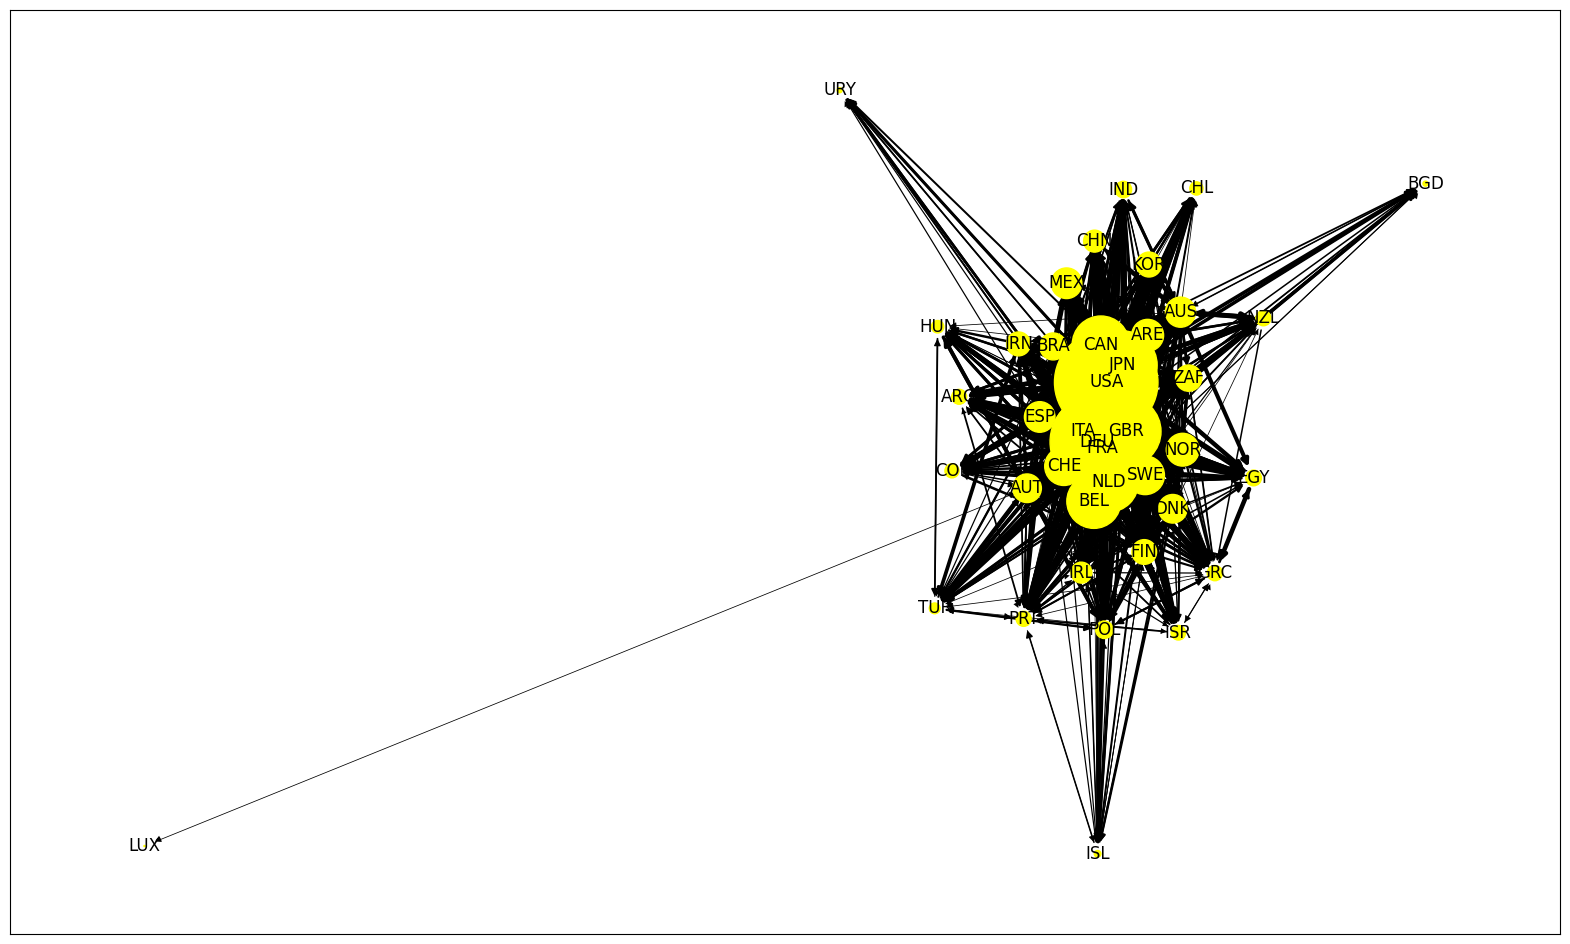

In [117]:
nx_graph1980 = plotGraph(g1980, exports1980)


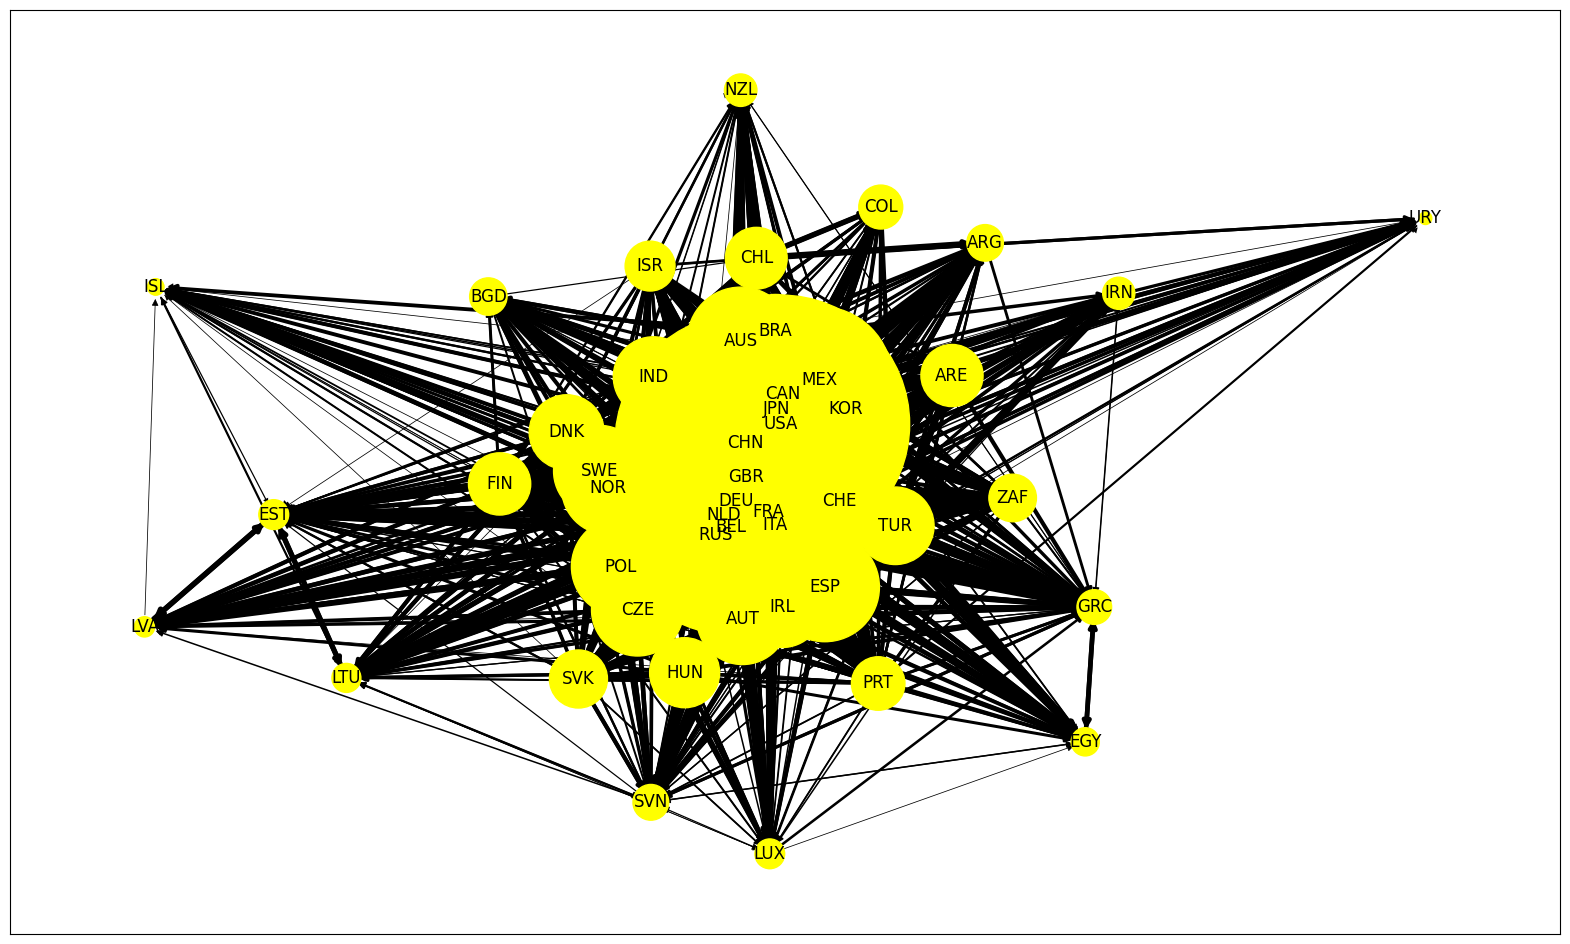

In [118]:
nx_graph2013 = plotGraph(g2013, exports2013)

<font size="+1" color="red">Replace this cell with a brief commentary on what are the similarities and differences you observe between these two graphs.</font>

In [ ]:
The similarities are that the same few nodes are in the center in both graphs (USA and some European countries) and the difference
is that the nodes got larger (indicating more trade) and the graph slightly rearranges with some countries being
pushed in (india) and some countries pushed out slightly (ARE- United arab emirates) but mostly the graph got more
centralized.

# 4. Compute hubs and authorities

<font size="+1" color="red">Replace this cell with your code for function *normalize*</font>

In [161]:
def normalize(dictionary):
    norm_dict  = dict([(element,dictionary[element]/sum(dictionary.values())) for element in dictionary.keys()])
    return norm_dict

In [162]:
# LEAVE AS-IS

print(normalize({"a": 39, "b": 13, "c":26}))

{'a': 0.5, 'b': 0.16666666666666666, 'c': 0.3333333333333333}


<font size="+1" color="red">Replace this cell with your code for function *hubs_authorities(graph, weight_key="weight")*. Remember to include comments to explain what your code does at every relevant step.</font>

In [338]:
def hubs_authorities(graph):
    graphnodes = set()
    for n in graph.nodes():
        graphnodes.add(n)
        
    #intialize hubs dict (left side of bipartite graph) -> every element the same 1/n
    hubs  = dict([(element,1/len(graphnodes)) for element in graphnodes])
    
    #start the algorithm
    for i in range(1, 100):
        #set authorities to zero
        authorities  = dict([(element,0) for element in graphnodes])
        #calculate authorities based on hub scored and edgeweight
        for auth_element in authorities.keys():
            for hub_element in hubs.keys():
                if auth_element != hub_element:
                    #if there is a hub->authority link  then multiply it by hub score otherwise it is zero
                    if graph.has_edge(auth_element, hub_element):
                        #value = graph[hub_element][auth_element]["weight"]*hubs[hub_element]
                        value = graph.get_edge_data(auth_element, hub_element)["weight"]*hubs[hub_element]
                    else:
                        value = 0
                    #add the weighted value to the previously summed weighted values
                    authorities[auth_element] = value + authorities[auth_element]
        authorities = normalize(authorities)
        #set hubs to zero
        hubs  = dict([(element,0) for element in graphnodes])
        #calculate hubs based on authorities score and edgeweight
        for hub_element in hubs.keys():
            for auth_element in authorities.keys():
                if auth_element != hub_element:
                    #if there is a authority->hub link then multiply it by authority score otherwise it is zero
                    if graph.has_edge(auth_element, hub_element):
                        value = graph.get_edge_data(auth_element, hub_element)["weight"]*authorities[auth_element]
                    else: 
                        value = 0
                    #add the weighted value to the previously summed weighted values
                    hubs[hub_element] = value + hubs[hub_element]
        #normalize it
        hubs = normalize(hubs)
    return authorities, hubs

In [357]:
# LEAVE AS-IS
# Execution should be very fast (a few seconds maximum)

print("Computing for 1980")
(h1980,a1980) = hubs_authorities(g1980)

print("Computing for 2013")
(h2013,a2013) = hubs_authorities(g2013)

Computing for 1980
Computing for 2013


In [358]:
# LEAVE AS-IS

flowsDF['h1980'] = pd.Series(h1980)
flowsDF['a1980'] = pd.Series(a1980)
flowsDF['h2013'] = pd.Series(h2013)
flowsDF['a2013'] = pd.Series(a2013)

flowsDF

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
ARE,1510,463,5717,7925,0.016822,0.005541,0.005204,0.006504
ARG,330,640,1977,2285,0.003986,0.008865,0.002373,0.002140
AUS,1347,1308,16945,13754,0.012905,0.015936,0.012657,0.021904
AUT,1212,1696,12465,13133,0.013344,0.020639,0.009377,0.013602
BEL,4331,4876,35176,34469,0.053995,0.059734,0.025724,0.027713
BGD,38,100,2071,430,0.000466,0.001249,0.002791,0.000418
BRA,1078,873,8069,9519,0.013615,0.013042,0.012940,0.008761
CAN,4874,4338,36490,34643,0.074716,0.079019,0.124175,0.045189
CHE,2179,2869,16784,16848,0.023722,0.032668,0.017403,0.017149
CHL,259,246,5645,5509,0.003308,0.003706,0.006034,0.008106


<font size="+1" color="red">Replace this cell with commands to print top countries by exports and by hub score.</font>

In [343]:
display(flowsDF.sort_values(by=["exp2013","h2013"], ascending=False).head(5))

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
DEU,13244,12315,107313,93033,0.116468,0.099733,0.075659,0.067515
CHN,715,1100,100868,49216,0.008104,0.014582,0.192611,0.044722
USA,15872,12724,98827,158024,0.145386,0.108776,0.049405,0.305855
JPN,6983,5903,42040,45426,0.076528,0.058000,0.060400,0.074513
NLD,5278,5300,40889,38469,0.063337,0.059884,0.027394,0.038653


<font size="+1" color="red">Replace this cell with a brief commentary in which you compare the two lists above. Explain clearly what does it mean to be a country with high hub score versus being a country with high total exports.</font>

In [ ]:
The two lists have similarities but they also differ because hubscore and exports are similar but different in meaning.
A country with a high hub  represents a country that exports to many other countries and exports represent
the total quantity of exports (a country can export to another one massive amounts having low hub but high export)

Print the top 5 countries by imports and by authority score in 2013.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with commands to print top countries by imports and by authority score.</font>

In [344]:
display(flowsDF.sort_values(by=["imp2013","a2013"], ascending=False).head(5))

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
USA,15872,12724,98827,158024,0.145386,0.108776,0.049405,0.305855
DEU,13244,12315,107313,93033,0.116468,0.099733,0.075659,0.067515
CHN,715,1100,100868,49216,0.008104,0.014582,0.192611,0.044722
FRA,7176,8208,40144,49065,0.073385,0.084250,0.029586,0.047689
GBR,7249,7555,33498,49037,0.067545,0.071357,0.033686,0.046123


<font size="+1" color="red">Replace this cell with a brief commentary in which you compare the two lists above. Explain clearly what does it mean to be a country with high authority score versus being a country with high total imports.</font>

In [ ]:
The two lists are similar but again differ because import and authority are not the same.
Countries with high authority have imports from many other countries (high exporting) while high import
countries countries just import vasts quantities of material (maybe from one country maybe from many)

# 5. Comparison of hub/export, authority/import scores

<font size="+1" color="red">Replace this cell with your function *plot_scatter*.</font>

In [353]:
def plot_scatter(a, b, x_label, y_label):
    # Create log-log plot
    plt.figure(figsize=(20,10))
    plt.loglog()
    plt.xlabel(x_label, {'size': '22'})
    plt.ylabel(y_label, {'size': '22'})

    # Add a diagonal line
    plt.plot([min(a.values()),max(a.values())], [min(b.values()),max(b.values())], '-.', lw=2)

    # Do the scatter plot with texts
    for country in set(a.keys()).intersection(set(b.keys())):
        plt.text(a[country], b[country], country, {'size': '12'})

    # Create log-log plot
#plt.figure(figsize=(20,10))
#plt.loglog()
#plt.xlabel("x axis label", {'size': '22'})
#plt.ylabel("y axis label", {'size': '22'})
# Add a diagonal line
#plt.plot([min(h2013.values()),max(h2013.values())], [min(exports2013.values()),max(exports2013.values())], '-.', lw=2)
# Do the scatter plot with texts
#for country in set(h2013.keys()).intersection(set(exports2013.keys())):
#    plt.text(h2013[country], exports2013[country], country, {'size': '12'})

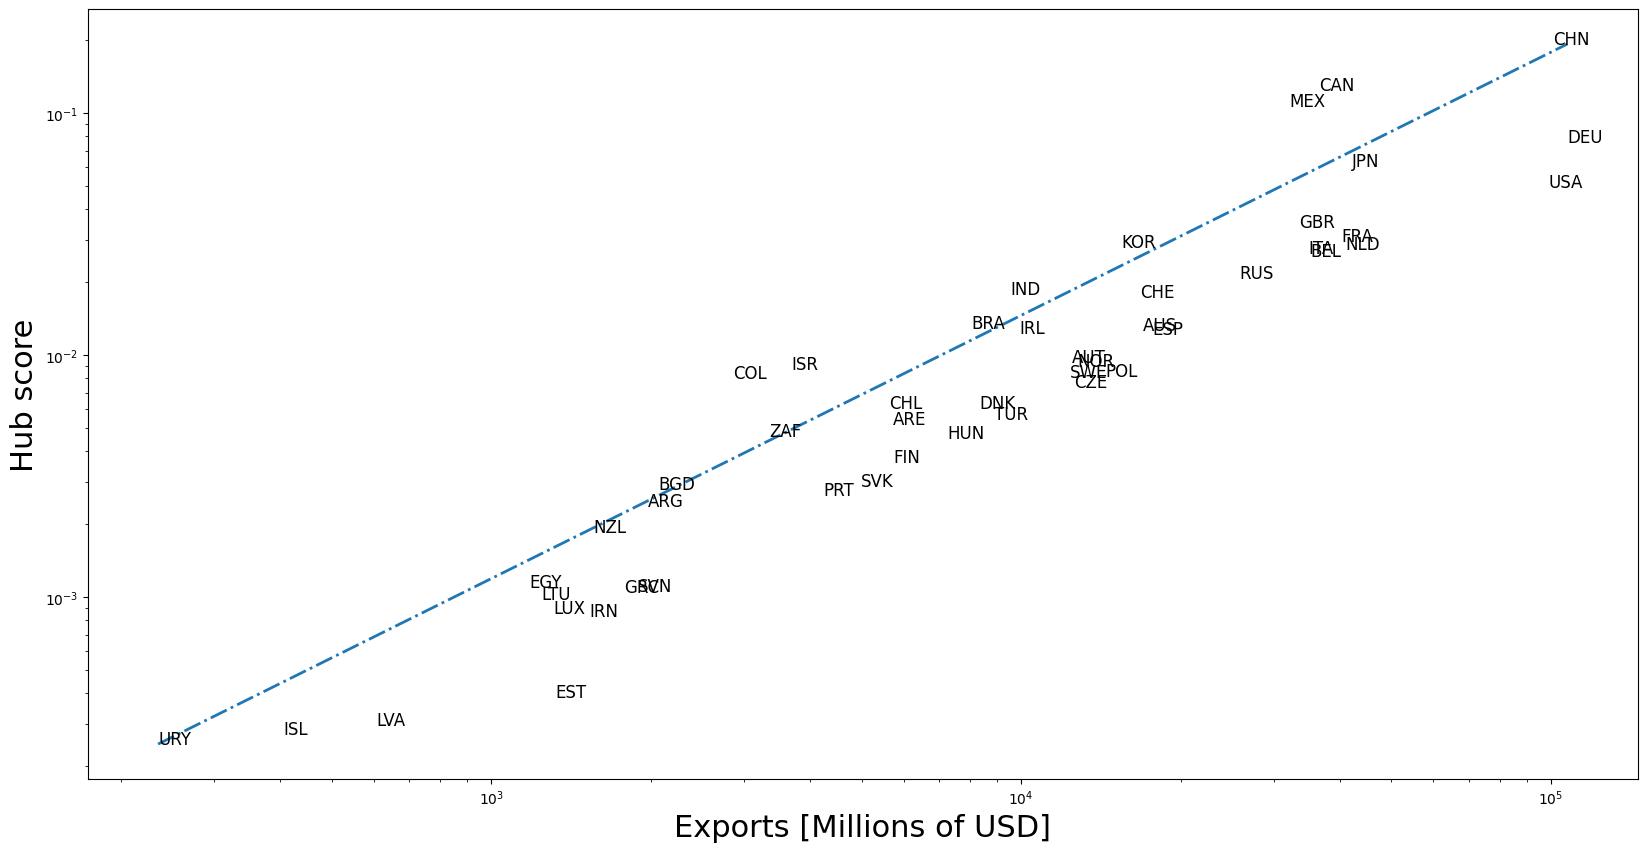

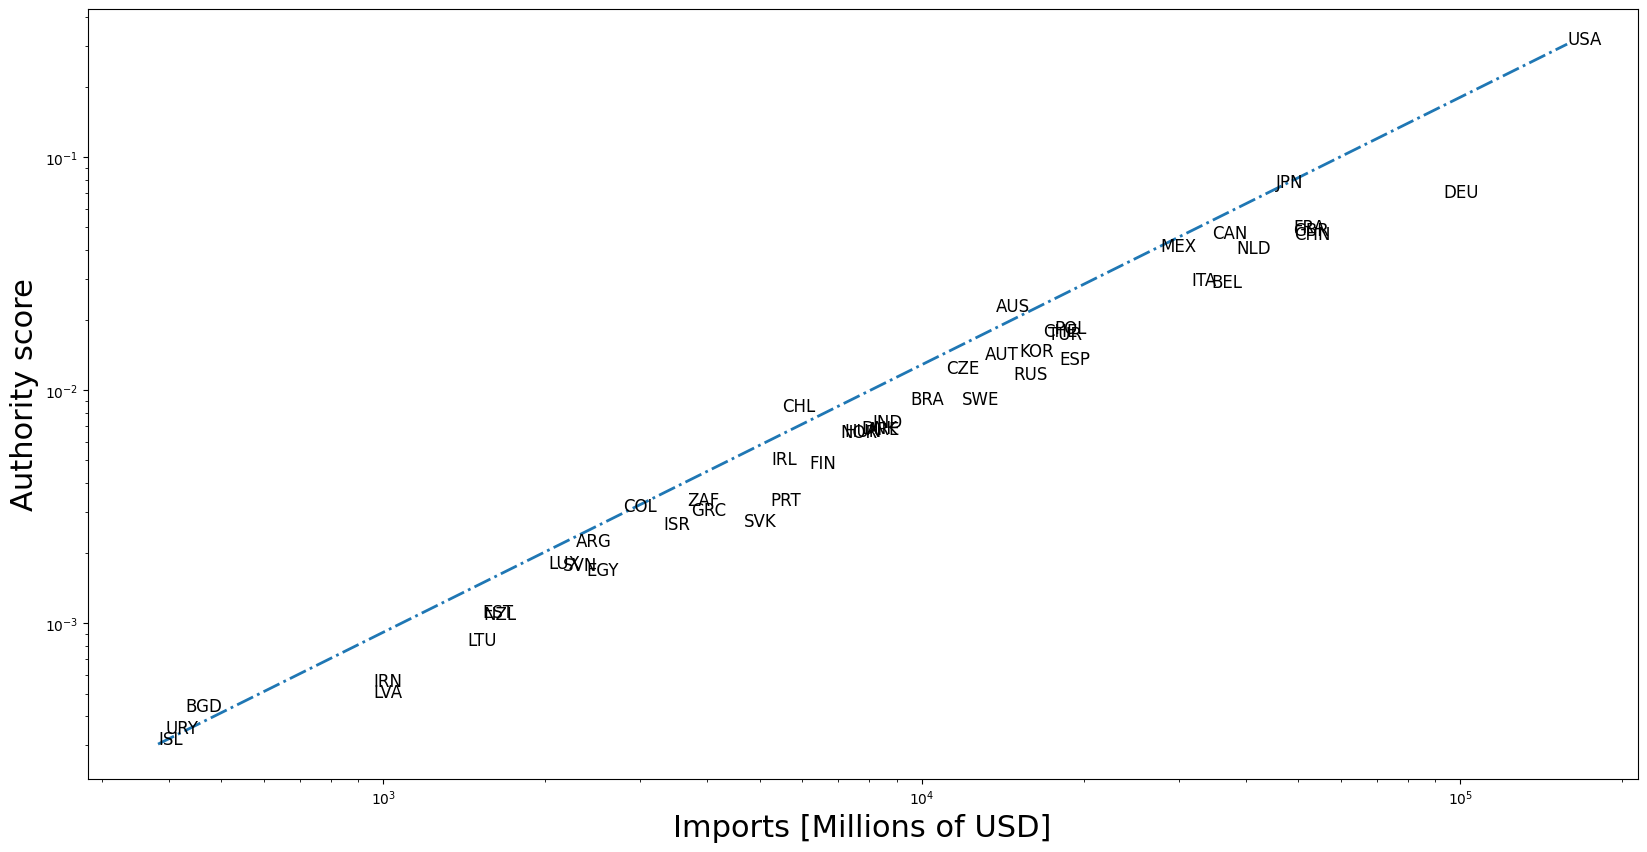

In [356]:
# LEAVE AS-IS: print plots for 2013

plot_scatter(exports2013, h2013, "Exports [Millions of USD]", "Hub score" )
plot_scatter(imports2013, a2013, "Imports [Millions of USD]", "Authority score" )

<font size="+1" color="red">Replace this cell with a brief commentary about the plots above with respect to (a) Hub scores versus exports, and (b) Authority scores versus imports.</font>

In [ ]:
In the authority-imports graph a direct correlation is clearly visible because of the y=x graph (indicating that the two
values are the same). In the hub-exports a correlation is also visible but it is not as prominent as the previous.

# DELIVER (individually)

A .zip file containing:

* This notebook.


## Extra points available

For extra points and extra learning (+2, so your maximum grade can be a 12 in this assignment), export this network to .csv, export the hub scores to a separate .csv file, and import both in Cytoscape. Then, do a clustering analysis in Cytoscape, paint the clusters with colors, resize nodes according to hub scores, and insert the image on this Notebook, with a brief commentary.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: country clusters</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>